In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import linregress
np.random.seed(1265)
from functools import reduce
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from shapely.geometry import Point, MultiPolygon, Polygon
from shapely.ops import unary_union
import os

###Machine Learning
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

##Supervised Learning
from sklearn.model_selection import cross_validate, KFold
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##Deep learning session
import tensorflow as tf
from keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(123)
tf.random.set_seed(123)

# Study of Location (Clean)

In [3]:
string_brackets_columns = ['resoFacts.patioAndPorchFeatures', 'resoFacts.waterSource', 'resoFacts.exteriorFeatures',
                           'resoFacts.interiorFeatures', 'resoFacts.communityFeatures', 'resoFacts.constructionMaterials',
                           'resoFacts.foundationDetails', 'resoFacts.utilities', 'resoFacts.appliances', 
                           'resoFacts.flooring', 'resoFacts.parkingFeatures',
                           'resoFacts.lotFeatures', 'resoFacts.fireplaceFeatures', 'resoFacts.laundryFeatures', 
                           'resoFacts.propertySubType', 'resoFacts.securityFeatures', 
                           'resoFacts.cooling', 'resoFacts.windowFeatures', 'resoFacts.heating', 'resoFacts.sewer', 
                           'resoFacts.poolFeatures']

string_comma_columns = ['resoFacts.architecturalStyle', 
                        'resoFacts.fencing', 'resoFacts.roofType']

t = string_brackets_columns + string_comma_columns
Selected_features = list(set(t) - set(['resoFacts.utilities', 'resoFacts.propertySubType']))

Year_list2022 = ['2022']
Month_list2022 = ['July', 'August', 'September', 'October', 'November', 'December']
Year_list2023 = ['2023']
Month_list2023 = ['January', 'February', 'March']

##This is a dictionary that stores the original data everymonth
original_data = dict()

##This is a dictionary that store the datasets for every month
monthly_data_dict1 = dict()

##This is a dictionary that store datasets to run analysis
monthly_data_dict2 = dict()
path_abs = "C:\\Users\\Khoatruong\\DATA365\\House Capstone Project\\Data cleaning\\Houses_categorical_property\\"

##Remove zipcode, city, county, SchoolDistrict since longitude and latitude will do the part

def read_house_data(Monthlist, Yearlist, original_data, monthly_data_dict1, monthly_data_dict2):
    for Year in Yearlist:
        for Month in Monthlist:
            main_df = pd.read_csv("C:\\Users\\Khoatruong\\DATA365\\House Capstone Project\\Data cleaning\\Clean_data_House_properties\\" + Month + '_' + Year + '\\houses_properties_' + Month + '.csv')
            cols = main_df.columns.tolist()

            ##Rename some columns
            for c in cols:
                if 'resoFacts.' in c:
                    feature = c.split('.')[1]
                    main_df[feature] = main_df[c]
                    main_df.drop(labels = [c], axis = 1, inplace = True)

            ##Drop unimportant features 
            main_df.drop(labels = ['streetAddress', 'countyId', 'hasCooling', 'hasHeating'], axis = 1, inplace = True)
            main_df.reset_index(drop = True, inplace = True)

            ##Join the categorical dataframes
            for category in Selected_features:
                ft = category.split('.')[1]
                name = 'houses' + '_' + ft + '.csv'
                df_cat = pd.read_csv(path_abs + Month + '_' + Year + '\\' + name)
                main_df = pd.merge(main_df, df_cat, how = 'left', on = 'zpid')

            string_list = ['city', 'county', 'SchoolDistrict', 'levels']
            for string in string_list:
                main_df[string] = main_df[string].str.lower()
            original_data[Month + '_' + Year] = main_df

            ##Need the zpid (zillow id) to keep track of the data
            #main_df.drop(labels = ['zpid'], axis = 1, inplace = True)
            monthly_data_dict1[Month + '_' + Year] = main_df

            remove_features = ['zipcode', 'city', 'SchoolDistrict', 'annualHomeownersInsurance']
            main_df2 = main_df.copy()
            main_df2.drop(labels = remove_features, axis = 1, inplace = True)
            monthly_data_dict2[Month + '_' + Year] = main_df2

In [4]:
read_house_data(Month_list2022, Year_list2022, original_data, monthly_data_dict1, monthly_data_dict2)
read_house_data(Month_list2023, Year_list2023, original_data, monthly_data_dict1, monthly_data_dict2)

In [5]:
for Month, df in monthly_data_dict1.items():
    monthly_data_dict1[Month]['zipcode'] = monthly_data_dict1[Month]['zipcode'].astype('int64')

In [6]:
###Drop houses that have lotArea = 0
###price per livingarea sqft or lot sqft have to make sense
###liv/lot ratio is really important, it can define which type of neighborhoods that the houses are in.
###liv/lot ratio can tell if that is a farm, urban, rural, suburban area
###however, the liv/lot ratio should not be greater than 2.
###Since, it makes the lotArea way more valuable than the livingArea, affect the performance of the model badly
###We also remove houses with price/lotsqft > 1000, these can be considered as expensive condos or apartments
for Month, df in monthly_data_dict1.items():
    monthly_data_dict1[Month]['price/livingsqft'] = monthly_data_dict1[Month]['price'] / monthly_data_dict1[Month]['livingAreaValue']
    monthly_data_dict1[Month]['price/lotsqft'] = monthly_data_dict1[Month]['price'] / monthly_data_dict1[Month]['lotArea']
    monthly_data_dict1[Month]['liv/lot_ratio'] = monthly_data_dict1[Month]['livingAreaValue'] / monthly_data_dict1[Month]['lotArea']
    df = df.copy().drop(df[(df['lotArea'] == 0) | (df['price/lotsqft'] > 1000) | (df['liv/lot_ratio'] > 2)
                           | (df['lotArea'] > 100000)].index)
    monthly_data_dict1[Month] = df

<AxesSubplot: >

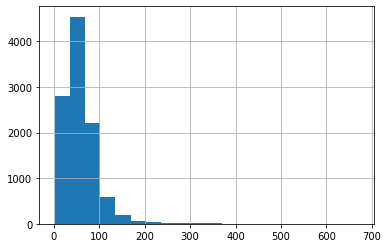

In [7]:
location_feb2023 = monthly_data_dict1['February_2023']
price_test = location_feb2023['price/lotsqft']
price_test.hist(bins = 20)

In [8]:
location_cols = ['zpid', 'latitude', 'longitude', 'county', 'SchoolDistrict', 'zipcode', 
                 'liv/lot_ratio', 'price/lotsqft', 'price/livingsqft']
monthly_location2 = dict()
for Month, df in monthly_data_dict1.items():
    ##Store the location data into this dictionary
    df_location = df.copy()[location_cols]
    monthly_location2[Month] = df_location

## Using Counties to plot our data
1. Plot datapoints with counties based on price per living square feet
2. Plot datapoints with counties based on price per lot square feet
3. Plot datapoints with counties based on ratio living:lot Area

In [9]:
##We have other counties that have the duplicated names but with different coordinates
##So for texas state we need to pick GEOID starting with 48 something
shape_df2 = gpd.read_file('ALL_US_county/tl_rd22_us_county.shp')
shape_df2['NAME'] = shape_df2['NAME'].str.lower()
shape_df2['INTPTLAT'] = shape_df2['INTPTLAT'].astype('float64')
shape_df2['INTPTLON'] = shape_df2['INTPTLON'].astype('float64')

all_counties_list = np.sort(monthly_data_dict1['February_2023']['county'].unique())
counties_location_df = shape_df2.copy()
counties_location_df = counties_location_df[(counties_location_df['NAME'].isin(all_counties_list)) & 
                                            (counties_location_df['GEOID'].str.contains('48'))].reset_index(drop = True)

In [10]:
month = 'February_2023'
location_feb2023 = monthly_location2[month]
location_feb2023

,zpid,latitude,longitude,county,SchoolDistrict,zipcode,liv/lot_ratio,price/lotsqft,price/livingsqft
0,7.894782e+07,33.361850,-97.696070,wise,alvord isd,76225,0.131690,12.003403,91.148649
1,2.399566e+08,33.164368,-97.439285,wise,decatur isd,76234,0.023229,2.509336,108.024691
2,7.893851e+07,33.076668,-97.565500,wise,boyd isd,76023,0.170679,28.232637,165.413534
3,7.894306e+07,33.292140,-97.807000,wise,chico isd,76431,0.059576,9.513091,159.680451
4,2.526456e+08,33.009575,-97.499040,wise,northwest isd,76071,0.014442,2.983378,206.582633
...,...,...,...,...,...,...,...,...,...
11192,3.054971e+08,32.527160,-96.781555,ellis,red oak isd,75154,0.118303,22.819375,192.888682
11194,1.223067e+08,32.517906,-96.915016,ellis,midlothian isd,76065,0.040526,11.051433,272.699101
11200,3.312331e+08,32.348778,-96.840440,ellis,waxahachie isd,75165,0.107461,28.466483,264.900662
11201,2.066871e+09,32.539078,-96.842514,ellis,red oak isd,75154,0.126557,26.485720,209.279070


In [11]:
##Using shapely to plot our map
def plot_map_feature(location_df, shapely_df, location, feature, vmin, vmax):
    fig, ax = plt.subplots(figsize=(10,10))
    # Plot the base map
    cm = plt.cm.get_cmap('inferno').reversed()
    lat = location_df['latitude'].to_numpy()
    long = location_df['longitude'].to_numpy()
    p = location_df[feature].to_numpy()

    loc_lat = shapely_df['INTPTLAT'].to_numpy()
    loc_long = shapely_df['INTPTLON'].to_numpy()

    shapely_df[['geometry']].plot(ax=ax, color='lightblue', linewidth = 1.2, edgecolor = 'darkblue', zorder = 1)
    ax0 = ax.scatter(long, lat, c = p, vmin = vmin, vmax = vmax, s = 3.5, cmap = cm, alpha = 0.8, zorder = 2)
    #plt.scatter(loc_long, loc_lat, s = 5, c = 'green', zorder = 3)

    #ax.set_xlim(-97.8, -96.2)
    #ax.set_ylim(32.3, 33.5)
    ax.set_title(month + " " + location + " and " + feature + " distribution")
    ax.set_xlabel('latitude')
    ax.set_ylabel('longtitude')
    fig.colorbar(ax0, shrink=0.62)
    fig.tight_layout()
    plt.show()

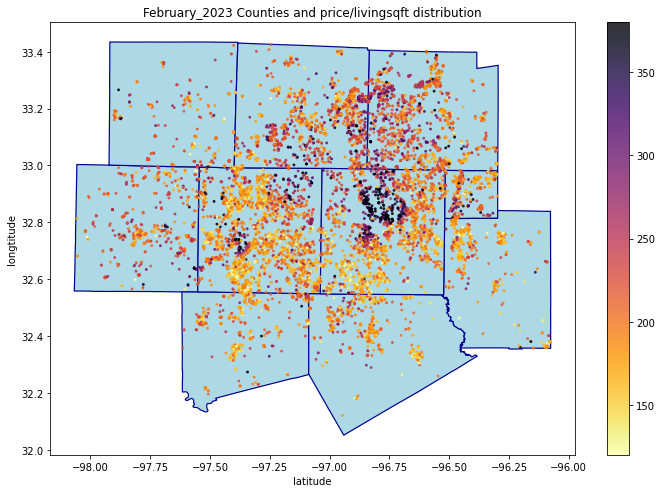

In [12]:
plot_map_feature(location_feb2023, counties_location_df, 'Counties', "price/livingsqft", 
                 vmin = 120, vmax = 380)

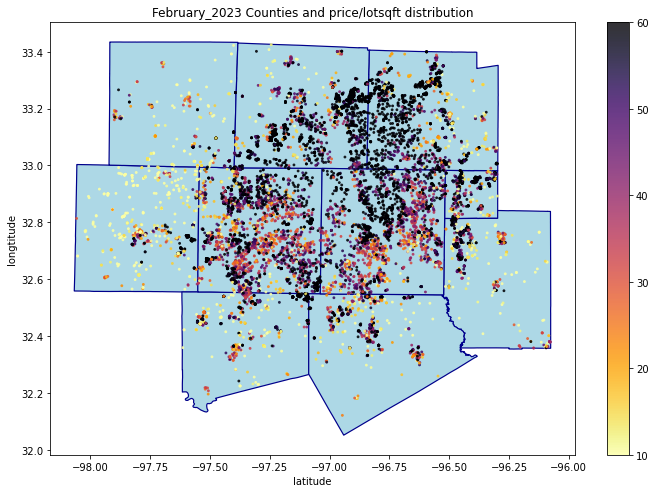

In [13]:
plot_map_feature(location_feb2023, counties_location_df, 'Counties', "price/lotsqft", 
                 vmin = 10, vmax = 60)

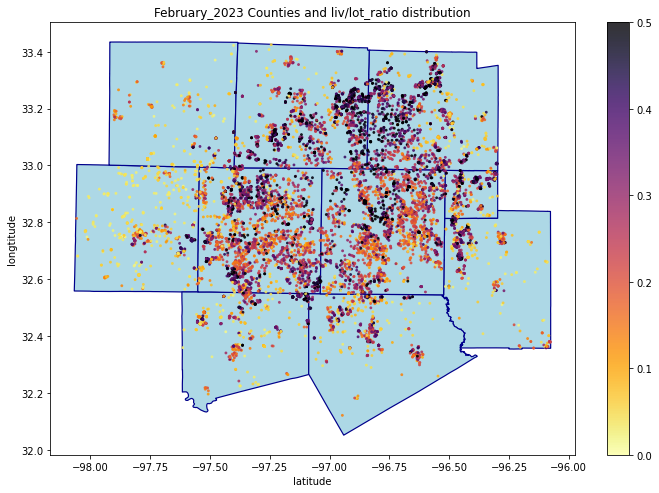

In [14]:
plot_map_feature(location_feb2023, counties_location_df, 'Counties', "liv/lot_ratio", 
                 vmin = 0, vmax = 0.5)

## Using SD to plot our data
1. Plot datapoints with school district based on price per living square feet
2. Plot datapoints with school district based on price per lot square feet
3. Plot datapoints with school district based on ratio living:lot Area

In [15]:
shape_df3 = gpd.read_file('Texas_SchoolDistrict/tl_rd22_48_unsd.shp')
shape_df3['NAME'] = shape_df3['NAME'].str.lower().replace('independent school district', 'isd', regex = True)
shape_df3['INTPTLAT'] = shape_df3['INTPTLAT'].astype('float64')
shape_df3['INTPTLON'] = shape_df3['INTPTLON'].astype('float64')

all_SD_list = np.sort(location_feb2023['SchoolDistrict'].unique())
SD_location_df = shape_df3.copy()
SD_location_df = SD_location_df[SD_location_df['NAME'].isin(all_SD_list) &
                               (SD_location_df['INTPTLON'] >= -98.5) & 
                               (SD_location_df['INTPTLON'] <= -95.8) &
                               (SD_location_df['INTPTLAT'] >= 32) &
                               (SD_location_df['INTPTLAT'] <= 33.70)].reset_index(drop = True)

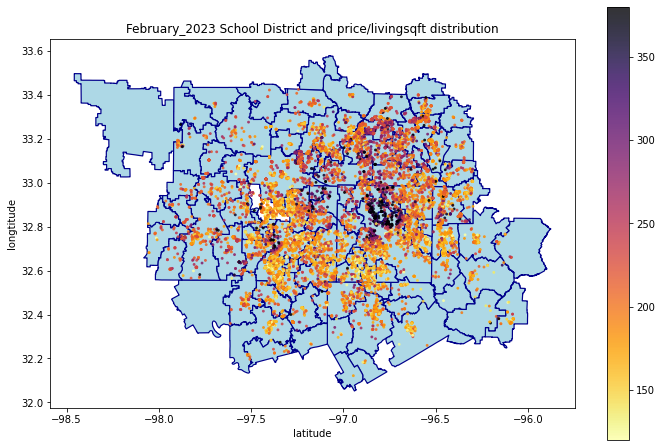

In [16]:
plot_map_feature(location_feb2023, SD_location_df, 'School District', "price/livingsqft", 
                 vmin = 120, vmax = 380)

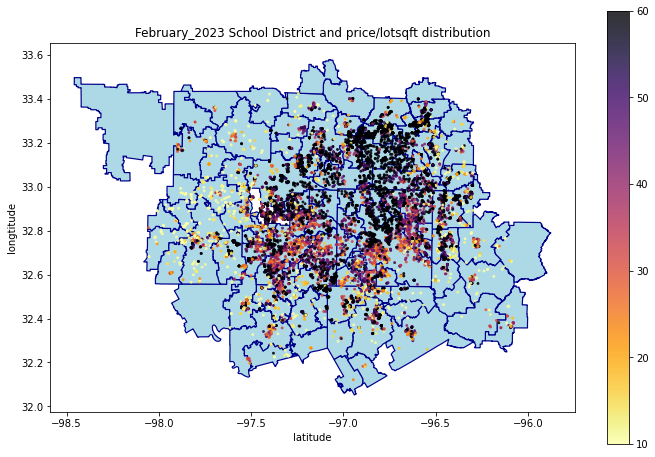

In [17]:
plot_map_feature(location_feb2023, SD_location_df, 'School District', "price/lotsqft", 
                 vmin = 10, vmax = 60)

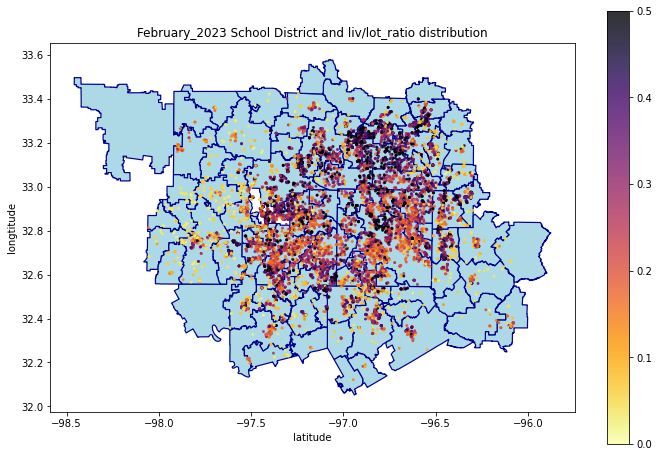

In [25]:
plot_map_feature(location_feb2023, SD_location_df, 'School District', "liv/lot_ratio", 
                 vmin = 0, vmax = 0.5)

## Using zipcode to plot our data
1. Plot datapoints with zipcode based on price per living square feet
2. Plot datapoints with zipcode based on price per lot square feet
3. Plot datapoints with zipcode based on ratio living:lot Area

In [19]:
shape_df4 = gpd.read_file('ALL_US_zipcode/tl_rd22_us_zcta520.shp')
shape_df4['ZCTA5CE20'] = shape_df4['ZCTA5CE20'].astype('int64')
shape_df4['GEOID20'] = shape_df4['GEOID20'].astype('int64')
shape_df4['INTPTLAT20'] = shape_df4['INTPTLAT20'].astype('float64')
shape_df4['INTPTLON20'] = shape_df4['INTPTLON20'].astype('float64')
shape_df4['INTPTLAT'] = shape_df4['INTPTLAT20']
shape_df4['INTPTLON'] = shape_df4['INTPTLON20']

all_zipcode_list = np.sort(location_feb2023['zipcode'].unique())
zipcode_location_df = shape_df4.copy()
zipcode_location_df = zipcode_location_df[zipcode_location_df['ZCTA5CE20'].isin(all_zipcode_list) &
                                         (zipcode_location_df['INTPTLON20'] >= -98.5) & 
                                         (zipcode_location_df['INTPTLON20'] <= -95.8) &
                                         (zipcode_location_df['INTPTLAT20'] >= 32) &
                                         (zipcode_location_df['INTPTLAT20'] <= 33.70)].reset_index(drop = True)

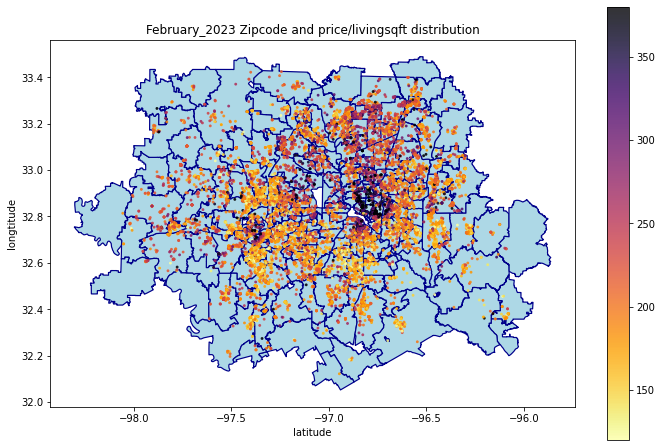

In [20]:
plot_map_feature(location_feb2023, zipcode_location_df, 'Zipcode', "price/livingsqft", 
                 vmin = 120, vmax = 380)

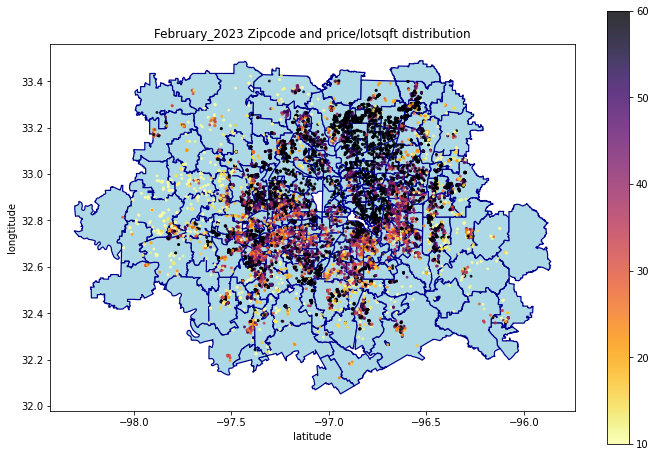

In [21]:
plot_map_feature(location_feb2023, zipcode_location_df, 'Zipcode', "price/lotsqft", 
                 vmin = 10, vmax = 60)

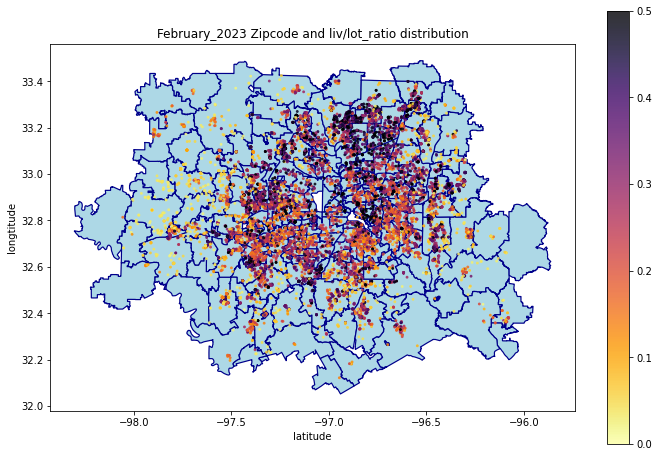

In [24]:
plot_map_feature(location_feb2023, zipcode_location_df, 'Zipcode', "liv/lot_ratio", 
                 vmin = 0, vmax = 0.5)

In [23]:
for Month, df in monthly_location2.items():
    counties_location_df['county_lat'] = counties_location_df['INTPTLAT']
    counties_location_df['county_long'] = counties_location_df['INTPTLON']
    counties_location_df['county'] = counties_location_df['NAME']
    
    SD_location_df['SD_lat'] = SD_location_df['INTPTLAT']
    SD_location_df['SD_long'] = SD_location_df['INTPTLON']
    SD_location_df['SchoolDistrict'] = SD_location_df['NAME']
    
    zipcode_location_df['zipcode_lat'] = zipcode_location_df['INTPTLAT']
    zipcode_location_df['zipcode_long'] = zipcode_location_df['INTPTLON']
    zipcode_location_df['zipcode'] = zipcode_location_df['ZCTA5CE20']
    
    merge_df = pd.merge(df, counties_location_df.copy()[['county', 'county_lat', 'county_long']], on=['county'], how='left')
    merge_df = pd.merge(merge_df, SD_location_df.copy()[['SchoolDistrict', 'SD_lat', 'SD_long']], on=['SchoolDistrict'], how='left')
    merge_df = pd.merge(merge_df, zipcode_location_df.copy()[['zipcode', 'zipcode_lat', 'zipcode_long']], on=['zipcode'], how='left')
    
    new_df = merge_df.copy()[['zpid', 'latitude', 'longitude', 'county_lat', 
                              'county_long', 'SD_lat', 'SD_long', 'zipcode_lat', 'zipcode_long', 
                              'price/livingsqft', 'price/lotsqft', 'liv/lot_ratio']]
    
    ###Check for null coords, if they are null, fill them with the coordinates of the houses
    new_df['SD_lat'].fillna(new_df['latitude'], inplace = True)
    new_df['SD_long'].fillna(new_df['longitude'], inplace = True)
    
    new_df['zipcode_lat'].fillna(new_df['latitude'], inplace = True)
    new_df['zipcode_long'].fillna(new_df['longitude'], inplace = True)
    
    new_df['county_lat'].fillna(new_df['latitude'], inplace = True)
    new_df['county_long'].fillna(new_df['longitude'], inplace = True)
    Monthly_path = 'Location_data3/' + Month
    if not os.path.exists(Monthly_path):
        os.makedirs(Monthly_path)
    
    new_df.to_csv(Monthly_path + '/' + Month + '_houses_location.csv', index = False)

### Living : Lot area ratio vs. price per lot area
1. Plot to see if there is a correlation between these 2 variables.

In [26]:
###11039 with price per lot area > 3000
###11034 with price per lot area > 1000
location_feb2023

,zpid,latitude,longitude,county,SchoolDistrict,zipcode,liv/lot_ratio,price/lotsqft,price/livingsqft
0,7.894782e+07,33.361850,-97.696070,wise,alvord isd,76225,0.131690,12.003403,91.148649
1,2.399566e+08,33.164368,-97.439285,wise,decatur isd,76234,0.023229,2.509336,108.024691
2,7.893851e+07,33.076668,-97.565500,wise,boyd isd,76023,0.170679,28.232637,165.413534
3,7.894306e+07,33.292140,-97.807000,wise,chico isd,76431,0.059576,9.513091,159.680451
4,2.526456e+08,33.009575,-97.499040,wise,northwest isd,76071,0.014442,2.983378,206.582633
...,...,...,...,...,...,...,...,...,...
11192,3.054971e+08,32.527160,-96.781555,ellis,red oak isd,75154,0.118303,22.819375,192.888682
11194,1.223067e+08,32.517906,-96.915016,ellis,midlothian isd,76065,0.040526,11.051433,272.699101
11200,3.312331e+08,32.348778,-96.840440,ellis,waxahachie isd,75165,0.107461,28.466483,264.900662
11201,2.066871e+09,32.539078,-96.842514,ellis,red oak isd,75154,0.126557,26.485720,209.279070


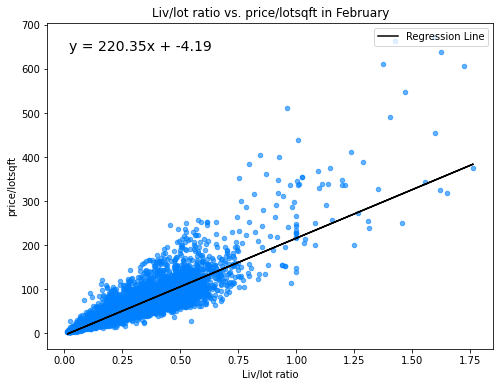

In [31]:
x = location_feb2023['liv/lot_ratio']
y = location_feb2023['price/lotsqft']

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, marker='o', color = (0, 0.5, 1), alpha = 0.6, s=20)
slope, intercept, r_value, p_value, std_err = linregress(x, y)
ax.plot(x, slope * x + intercept, color='black', label='Regression Line')
ax.text(0.05, 0.95, f'y = {slope:.2f}x + {intercept:.2f}', transform=ax.transAxes, fontsize=14, verticalalignment='top')
plt.title('Liv/lot ratio vs. price/lotsqft in February')
plt.xlabel('Liv/lot ratio')
plt.ylabel('price/lotsqft')
ax.legend(loc = 'upper right')
plt.show()

In [32]:
location_feb2023[['liv/lot_ratio', 'price/lotsqft']].corr()

,liv/lot_ratio,price/lotsqft
liv/lot_ratio,1.000000,0.869842
price/lotsqft,0.869842,1.000000


#### Machine Learning on location
1. Using the February data for ML
2. Prep the data for ML
3. Build different models

In [27]:
df_location2 = pd.read_csv('Location_data3/February_2023/February_2023_houses_location.csv')
df_location2

,zpid,latitude,longitude,county_lat,county_long,SD_lat,SD_long,zipcode_lat,zipcode_long,price/livingsqft,price/lotsqft,liv/lot_ratio
0,7.894782e+07,33.361850,-97.696070,33.219095,-97.653997,33.379846,-97.701165,33.374041,-97.667809,91.148649,12.003403,0.131690
1,2.399566e+08,33.164368,-97.439285,33.219095,-97.653997,33.237630,-97.539224,33.276319,-97.514178,108.024691,2.509336,0.023229
2,7.893851e+07,33.076668,-97.565500,33.219095,-97.653997,33.072593,-97.579633,33.041952,-97.597065,165.413534,28.232637,0.170679
3,7.894306e+07,33.292140,-97.807000,33.219095,-97.653997,33.326269,-97.829165,33.302787,-97.868426,159.680451,9.513091,0.059576
4,2.526456e+08,33.009575,-97.499040,33.219095,-97.653997,33.033006,-97.354880,33.011335,-97.474362,206.582633,2.983378,0.014442
...,...,...,...,...,...,...,...,...,...,...,...,...
11012,2.059999e+09,32.365173,-96.935650,32.346878,-96.796940,32.356339,-96.863493,32.360829,-96.915523,1390.625000,1.292395,0.000929
11013,3.312331e+08,32.348778,-96.840440,32.346878,-96.796940,32.356339,-96.863493,32.371654,-96.803030,264.900662,28.466483,0.107461
11014,2.066871e+09,32.539078,-96.842514,32.346878,-96.796940,32.515389,-96.811019,32.524259,-96.809069,209.279070,26.485720,0.126557
11015,9.889846e+07,32.543800,-97.011894,32.346878,-96.796940,32.472297,-97.000465,32.584814,-96.972312,221.691678,22.315972,0.100662


In [28]:
df_model = df_location2.copy()[['latitude', 'longitude', 'county_lat', 'county_long', 'liv/lot_ratio', 
                                'SD_lat', 'SD_long', 'zipcode_lat', 'zipcode_long', 'price/lotsqft']]
df_model

,latitude,longitude,county_lat,county_long,liv/lot_ratio,SD_lat,SD_long,zipcode_lat,zipcode_long,price/lotsqft
0,33.361850,-97.696070,33.219095,-97.653997,0.131690,33.379846,-97.701165,33.374041,-97.667809,12.003403
1,33.164368,-97.439285,33.219095,-97.653997,0.023229,33.237630,-97.539224,33.276319,-97.514178,2.509336
2,33.076668,-97.565500,33.219095,-97.653997,0.170679,33.072593,-97.579633,33.041952,-97.597065,28.232637
3,33.292140,-97.807000,33.219095,-97.653997,0.059576,33.326269,-97.829165,33.302787,-97.868426,9.513091
4,33.009575,-97.499040,33.219095,-97.653997,0.014442,33.033006,-97.354880,33.011335,-97.474362,2.983378
...,...,...,...,...,...,...,...,...,...,...
11012,32.365173,-96.935650,32.346878,-96.796940,0.000929,32.356339,-96.863493,32.360829,-96.915523,1.292395
11013,32.348778,-96.840440,32.346878,-96.796940,0.107461,32.356339,-96.863493,32.371654,-96.803030,28.466483
11014,32.539078,-96.842514,32.346878,-96.796940,0.126557,32.515389,-96.811019,32.524259,-96.809069,26.485720
11015,32.543800,-97.011894,32.346878,-96.796940,0.100662,32.472297,-97.000465,32.584814,-96.972312,22.315972


In [2]:
def prep_data(splits, scaler, df_model):
    data = df_model.to_numpy()
    cv = KFold(n_splits = splits, shuffle = True, random_state = 0)
    cv.split(data)

    train_set_dict = dict()
    train_target_dict = dict()
    scaled_train_set = dict()
    scaled_train_target = dict()

    test_set_dict = dict()
    test_target_dict = dict()
    scaled_test_set = dict()
    scaled_test_target = dict()

    ###Store K folds data into dictionary
    for i, (train_index, test_index) in enumerate(cv.split(data)):
        train_set = df_model.iloc[train_index].iloc[:, :-1]
        train_target = df_model.iloc[train_index].iloc[:, -1]
        train_set_dict['Fold ' + str(i)] = train_set.copy()
        train_target_dict['Fold ' + str(i)] = train_target.copy()

        test_set = df_model.iloc[test_index].iloc[:, :-1]
        test_target = df_model.iloc[test_index].iloc[:, -1]
        test_set_dict['Fold ' + str(i)] = test_set.copy()
        test_target_dict['Fold ' + str(i)] = test_target.copy()
        
        the_scaler = scaler
        scaled_train_set['Fold ' + str(i)] = the_scaler.fit_transform(train_set)
        scaled_train_target['Fold ' + str(i)] = np.log(train_target_dict['Fold ' + str(i)]).to_numpy().reshape(-1, 1)
        scaled_test_set['Fold ' + str(i)] = the_scaler.transform(test_set)
        scaled_test_target['Fold ' + str(i)] = np.log(test_target_dict['Fold ' + str(i)]).to_numpy().reshape(-1, 1)
        
    return (train_set_dict, train_target_dict, scaled_train_set, scaled_train_target,
            test_set_dict, test_target_dict, scaled_test_set, scaled_test_target)

In [30]:
splits = 5
scaler3 = MinMaxScaler()
all_dicts3 = prep_data(splits, scaler3, df_model)
train_set3 = all_dicts3[0]
train_target3 = all_dicts3[1]
scaled_train_set3 = all_dicts3[2]
scaled_train_target3 = all_dicts3[3]

test_set3 = all_dicts3[4]
test_target3 = all_dicts3[5]
scaled_test_set3 = all_dicts3[6]
scaled_test_target3 = all_dicts3[7]

In [31]:
R2_list = list()
adjusted_R2_list = list()
rmse_list = list()
mae_list = list()

for i in range(5):
    KNN_r = KNeighborsRegressor(n_neighbors = 30, weights = 'distance')
    train_set = scaled_train_set3['Fold ' + str(i)]
    train_target = train_target3['Fold ' + str(i)].to_numpy()
    test_set = scaled_test_set3['Fold ' + str(i)]
    test_target = test_target3['Fold ' + str(i)].to_numpy()
    KNN_r.fit(train_set, train_target)
    
    test_observed = test_target3['Fold ' + str(i)].to_numpy().reshape(-1, 1)
    test_predicted = KNN_r.predict(test_set)
    r2 = r2_score(test_observed, test_predicted)
    n = test_observed.shape[0]
    p = train_set.shape[1]
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    mse = mean_squared_error(test_observed, test_predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_observed, test_predicted)

    R2_list.append(r2)
    adjusted_R2_list.append(adjusted_r2)
    rmse_list.append(rmse)
    mae_list.append(mae)
    
    print("Fold " + str(i + 1) + " Test R-squared score:", np.round(r2, 4))
    print("Fold " + str(i + 1) + " Test Adjusted R-squared score:", np.round(adjusted_r2, 4))
    print("Fold " + str(i + 1) + " RMSE:", np.round(rmse, 4))
    print("Fold " + str(i + 1) + " MAE:", np.round(mae, 4))
    print()
    

print("The average Test R-squared : ", np.round(sum(R2_list)/len(R2_list), 4))
print("The average Test adjusted R-squared: ", np.round(sum(adjusted_R2_list)/len(adjusted_R2_list), 4))
print("The average deviation from actual value (RMSE): ", np.round(sum(rmse_list)/len(rmse_list), 4))
print("The average deviation from actual value (MAE): ", np.round(sum(mae_list)/len(mae_list), 4))

Fold 1 Test R-squared score: 0.8897
Fold 1 Test Adjusted R-squared score: 0.8892
Fold 1 RMSE: 12.7579
Fold 1 MAE: 8.0115

Fold 2 Test R-squared score: 0.8683
Fold 2 Test Adjusted R-squared score: 0.8678
Fold 2 RMSE: 15.4743
Fold 2 MAE: 8.1024

Fold 3 Test R-squared score: 0.8688
Fold 3 Test Adjusted R-squared score: 0.8683
Fold 3 RMSE: 15.4752
Fold 3 MAE: 8.4856

Fold 4 Test R-squared score: 0.8967
Fold 4 Test Adjusted R-squared score: 0.8963
Fold 4 RMSE: 14.8209
Fold 4 MAE: 8.1424

Fold 5 Test R-squared score: 0.8832
Fold 5 Test Adjusted R-squared score: 0.8827
Fold 5 RMSE: 14.3688
Fold 5 MAE: 8.1088

The average Test R-squared :  0.8813
The average Test adjusted R-squared:  0.8809
The average deviation from actual value (RMSE):  14.5794
The average deviation from actual value (MAE):  8.1701


### Build More Models

In [3]:
##Assume I didn't scale the test targets into other values
def location_ml(model, train_set_dict, train_target_dict, test_set_dict, test_target_dict, verbose = 0):
    Test_R2_list = list()
    Test_adjusted_R2_list = list()
    Train_R2_list = list()
    rmse_list = list()
    mae_list = list()

    for i in range(5):
        train_set = train_set_dict['Fold ' + str(i)]
        train_target = train_target_dict['Fold ' + str(i)].to_numpy()
        test_set = test_set_dict['Fold ' + str(i)]
        test_target = test_target_dict['Fold ' + str(i)].to_numpy()
        model.fit(train_set, train_target)
        train_r_squared = model.score(train_set, train_target)
        
        test_observed = test_target_dict['Fold ' + str(i)].to_numpy().reshape(-1, 1)
        test_predicted = model.predict(test_set)
        r2 = r2_score(test_observed, test_predicted)
        n = test_observed.shape[0]
        p = train_set.shape[1]
        adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
        mse = mean_squared_error(test_observed, test_predicted)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test_observed, test_predicted)

        Test_R2_list.append(r2)
        Test_adjusted_R2_list.append(adjusted_r2)
        Train_R2_list.append(train_r_squared)
        rmse_list.append(rmse)
        mae_list.append(mae)
        
        if verbose == 1:
            print("Fold " + str(i + 1) + " Test R-squared score:", np.round(r2, 4))
            print("Fold " + str(i + 1) + " Test Adjusted R-squared score:", np.round(adjusted_r2, 4))
            print("Fold " + str(i + 1) + " RMSE:", np.round(rmse, 4))
            print("Fold " + str(i + 1) + " MAE:", np.round(mae, 4))
            print()
    dif = np.round(sum(Train_R2_list)/len(Train_R2_list), 4) - np.round(sum(Test_R2_list)/len(Test_R2_list), 4)
    dif = np.round(dif * 100, 2)
    if verbose == 1:
        print("The average Train R-squared : ", np.round(sum(Train_R2_list)/len(Train_R2_list), 4))
        print("The average Test R-squared : ", np.round(sum(Test_R2_list)/len(Test_R2_list), 4))
        print("The average Test adjusted R-squared: ", np.round(sum(Test_adjusted_R2_list)/len(Test_adjusted_R2_list), 4))
        print("The average deviation from actual value (RMSE): ", np.round(sum(rmse_list)/len(rmse_list), 4))
        print("The average deviation from actual value (MAE): ", np.round(sum(mae_list)/len(mae_list), 4))
        print("Difference between Train vs. Test R-squared: ", dif, "%")
    avg_Train_R2 = np.round(sum(Train_R2_list)/len(Train_R2_list), 4)
    avg_Test_R2 = np.round(sum(Test_R2_list)/len(Test_R2_list), 4)
    avg_Test_adjusted_R2 = np.round(sum(Test_adjusted_R2_list)/len(Test_adjusted_R2_list), 4)
    avg_Test_RMSE = np.round(sum(rmse_list)/len(rmse_list), 4)
    avg_Test_MAE = np.round(sum(mae_list)/len(mae_list), 4)
    return (avg_Train_R2, avg_Test_R2, avg_Test_adjusted_R2, avg_Test_RMSE, avg_Test_MAE, dif)

In [33]:
RF = RandomForestRegressor()
avg_Train_R2, avg_Test_R2, avg_Test_adjusted_R2, avg_Test_RMSE, avg_Test_MAE, dif = location_ml(RF, train_set3, train_target3, test_set3, test_target3, verbose = 1)

Fold 1 Test R-squared score: 0.9105
Fold 1 Test Adjusted R-squared score: 0.9101
Fold 1 RMSE: 11.492
Fold 1 MAE: 6.9289

Fold 2 Test R-squared score: 0.8986
Fold 2 Test Adjusted R-squared score: 0.8982
Fold 2 RMSE: 13.5771
Fold 2 MAE: 7.2581

Fold 3 Test R-squared score: 0.8878
Fold 3 Test Adjusted R-squared score: 0.8874
Fold 3 RMSE: 14.3086
Fold 3 MAE: 7.6863

Fold 4 Test R-squared score: 0.9192
Fold 4 Test Adjusted R-squared score: 0.9189
Fold 4 RMSE: 13.1081
Fold 4 MAE: 7.3834

Fold 5 Test R-squared score: 0.9121
Fold 5 Test Adjusted R-squared score: 0.9117
Fold 5 RMSE: 12.4658
Fold 5 MAE: 7.0095

The average Train R-squared :  0.986
The average Test R-squared :  0.9056
The average Test adjusted R-squared:  0.9053
The average deviation from actual value (RMSE):  12.9903
The average deviation from actual value (MAE):  7.2532
Difference between Train vs. Test R-squared:  8.04 %


In [34]:
RF2 = RandomForestRegressor()
avg_Train_R2, avg_Test_R2, avg_Test_adjusted_R2, avg_Test_RMSE, avg_Test_MAE, dif = location_ml(RF2, scaled_train_set3, train_target3, scaled_test_set3, test_target3, verbose = 1)

Fold 1 Test R-squared score: 0.9111
Fold 1 Test Adjusted R-squared score: 0.9107
Fold 1 RMSE: 11.4567
Fold 1 MAE: 6.9186

Fold 2 Test R-squared score: 0.8982
Fold 2 Test Adjusted R-squared score: 0.8978
Fold 2 RMSE: 13.6048
Fold 2 MAE: 7.2078

Fold 3 Test R-squared score: 0.8902
Fold 3 Test Adjusted R-squared score: 0.8898
Fold 3 RMSE: 14.1541
Fold 3 MAE: 7.6336

Fold 4 Test R-squared score: 0.9156
Fold 4 Test Adjusted R-squared score: 0.9152
Fold 4 RMSE: 13.4019
Fold 4 MAE: 7.4421

Fold 5 Test R-squared score: 0.9088
Fold 5 Test Adjusted R-squared score: 0.9084
Fold 5 RMSE: 12.6946
Fold 5 MAE: 7.0862

The average Train R-squared :  0.9862
The average Test R-squared :  0.9048
The average Test adjusted R-squared:  0.9044
The average deviation from actual value (RMSE):  13.0624
The average deviation from actual value (MAE):  7.2576
Difference between Train vs. Test R-squared:  8.14 %


In [35]:
HGBR = HistGradientBoostingRegressor()
avg_Train_R2, avg_Test_R2, avg_Test_adjusted_R2, avg_Test_RMSE, avg_Test_MAE, dif = location_ml(HGBR, train_set3, train_target3, test_set3, test_target3, verbose = 1)

Fold 1 Test R-squared score: 0.9033
Fold 1 Test Adjusted R-squared score: 0.9029
Fold 1 RMSE: 11.9472
Fold 1 MAE: 6.9661

Fold 2 Test R-squared score: 0.8922
Fold 2 Test Adjusted R-squared score: 0.8917
Fold 2 RMSE: 14.0011
Fold 2 MAE: 7.0687

Fold 3 Test R-squared score: 0.8878
Fold 3 Test Adjusted R-squared score: 0.8873
Fold 3 RMSE: 14.3128
Fold 3 MAE: 7.6115

Fold 4 Test R-squared score: 0.9126
Fold 4 Test Adjusted R-squared score: 0.9122
Fold 4 RMSE: 13.6352
Fold 4 MAE: 7.4688

Fold 5 Test R-squared score: 0.8966
Fold 5 Test Adjusted R-squared score: 0.8962
Fold 5 RMSE: 13.5153
Fold 5 MAE: 7.1503

The average Train R-squared :  0.935
The average Test R-squared :  0.8985
The average Test adjusted R-squared:  0.8981
The average deviation from actual value (RMSE):  13.4823
The average deviation from actual value (MAE):  7.2531
Difference between Train vs. Test R-squared:  3.65 %


In [36]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
avg_Train_R2, avg_Test_R2, avg_Test_adjusted_R2, avg_Test_RMSE, avg_Test_MAE, dif = location_ml(xg_reg, train_set3, train_target3, test_set3, test_target3, verbose = 1)

Fold 1 Test R-squared score: 0.9187
Fold 1 Test Adjusted R-squared score: 0.9184
Fold 1 RMSE: 10.9538
Fold 1 MAE: 6.7616

Fold 2 Test R-squared score: 0.9209
Fold 2 Test Adjusted R-squared score: 0.9206
Fold 2 RMSE: 11.9914
Fold 2 MAE: 6.6879

Fold 3 Test R-squared score: 0.904
Fold 3 Test Adjusted R-squared score: 0.9036
Fold 3 RMSE: 13.2385
Fold 3 MAE: 7.4513

Fold 4 Test R-squared score: 0.9254
Fold 4 Test Adjusted R-squared score: 0.9251
Fold 4 RMSE: 12.5933
Fold 4 MAE: 7.2708

Fold 5 Test R-squared score: 0.9193
Fold 5 Test Adjusted R-squared score: 0.919
Fold 5 RMSE: 11.9437
Fold 5 MAE: 6.8512

The average Train R-squared :  0.9789
The average Test R-squared :  0.9177
The average Test adjusted R-squared:  0.9173
The average deviation from actual value (RMSE):  12.1441
The average deviation from actual value (MAE):  7.0046
Difference between Train vs. Test R-squared:  6.12 %


##### Tuning the xgboost model

In [37]:
xg_reg = xgb.XGBRegressor(n_estimators = 100, eta = 0.15, objective ='reg:squarederror', min_split_loss = 0.4, 
                          reg_lambda = 1, reg_alpha = 0.75, max_depth = 6)
avg_Train_R2, avg_Test_R2, avg_Test_adjusted_R2, avg_Test_RMSE, avg_Test_MAE, dif = location_ml(xg_reg, train_set3, train_target3, test_set3, test_target3, verbose = 1)

Fold 1 Test R-squared score: 0.9176
Fold 1 Test Adjusted R-squared score: 0.9173
Fold 1 RMSE: 11.0277
Fold 1 MAE: 6.7495

Fold 2 Test R-squared score: 0.9149
Fold 2 Test Adjusted R-squared score: 0.9145
Fold 2 RMSE: 12.4399
Fold 2 MAE: 6.8728

Fold 3 Test R-squared score: 0.9091
Fold 3 Test Adjusted R-squared score: 0.9087
Fold 3 RMSE: 12.8833
Fold 3 MAE: 7.2659

Fold 4 Test R-squared score: 0.9248
Fold 4 Test Adjusted R-squared score: 0.9245
Fold 4 RMSE: 12.6428
Fold 4 MAE: 7.2454

Fold 5 Test R-squared score: 0.9189
Fold 5 Test Adjusted R-squared score: 0.9186
Fold 5 RMSE: 11.9697
Fold 5 MAE: 6.8878

The average Train R-squared :  0.9666
The average Test R-squared :  0.9171
The average Test adjusted R-squared:  0.9167
The average deviation from actual value (RMSE):  12.1927
The average deviation from actual value (MAE):  7.0043
Difference between Train vs. Test R-squared:  4.95 %


In [38]:
###This is the best performance model so far.
###Need to build a deep learning model for the comparison

#### Deep learning session

In [38]:
###Deep learning session requires restarting the kernel to get a better accurate result
###Therefore, need to read all of the monthly dataframes, and then prep the data up
###August_2022, September_2022, October_2022, November_2022, January_2023, February_2023, March_2023 is fine
###July_2022 and December_2022 not fine (fixed)
df_location2 = pd.read_csv('Location_data3/December_2022/December_2022_houses_location.csv')
#df_location2 = df_location2.loc[df_location2['liv/lot_ratio'] < 2]
df_model = df_location2.copy()[['latitude', 'longitude', 'county_lat', 'county_long', 'liv/lot_ratio', 
                                'SD_lat', 'SD_long', 'zipcode_lat', 'zipcode_long', 'price/lotsqft']]
splits = 5
scaler3 = MinMaxScaler()
all_dicts3 = prep_data(splits, scaler3, df_model)
train_set3 = all_dicts3[0]
train_target3 = all_dicts3[1]
scaled_train_set3 = all_dicts3[2]
scaled_train_target3 = all_dicts3[3]

test_set3 = all_dicts3[4]
test_target3 = all_dicts3[5]
scaled_test_set3 = all_dicts3[6]
scaled_test_target3 = all_dicts3[7]

In [4]:
def ann_generator(input_shape):
    T = input_shape
    i = Input(shape = [T,])
    x = Dense(2000)(i)
    x = Activation('relu')(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1)(x)
    model = Model(inputs = i, outputs = output)
    
    return model

In [5]:
input_shape = train_set3['Fold 0'].shape[1]
model1 = ann_generator(input_shape)
model1.summary()

NameError: name 'train_set3' is not defined

In [41]:
np.random.seed(123)
tf.random.set_seed(123)

initial_learning_rate = 0.001
decay_steps = 990
decay_rate = 0.85
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)
Adam = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
model1.compile(loss = 'mean_squared_error', optimizer = Adam, metrics = ['mse'])
check_point = ModelCheckpoint('Location_ANN_vars/model1_adam_ann.h5', monitor = 'val_mse', save_best_only = True)

Xtrain = scaled_train_set3['Fold 0']
ytrain = scaled_train_target3['Fold 0']
Xval = scaled_test_set3['Fold 0']
yval = scaled_test_target3['Fold 0']

result1 = model1.fit(Xtrain, ytrain, epochs = 65, validation_data = (Xval, yval), 
                     batch_size = 32, callbacks = [check_point])

Epoch 1/65
284/284 [==============================] - 3s 6ms/step - loss: 0.6853 - mse: 0.6853 - val_loss: 0.1918 - val_mse: 0.1918
Epoch 2/65
284/284 [==============================] - 1s 5ms/step - loss: 0.1960 - mse: 0.1960 - val_loss: 0.1436 - val_mse: 0.1436
Epoch 3/65
284/284 [==============================] - 2s 6ms/step - loss: 0.1531 - mse: 0.1531 - val_loss: 0.0863 - val_mse: 0.0863
Epoch 4/65
284/284 [==============================] - 2s 7ms/step - loss: 0.1177 - mse: 0.1177 - val_loss: 0.0615 - val_mse: 0.0615
Epoch 5/65
284/284 [==============================] - 2s 7ms/step - loss: 0.1123 - mse: 0.1123 - val_loss: 0.0760 - val_mse: 0.0760
Epoch 6/65
284/284 [==============================] - 2s 8ms/step - loss: 0.1052 - mse: 0.1052 - val_loss: 0.0570 - val_mse: 0.0570
Epoch 7/65
284/284 [==============================] - 2s 7ms/step - loss: 0.0993 - mse: 0.0993 - val_loss: 0.0879 - val_mse: 0.0879
Epoch 8/65
284/284 [==============================] - 2s 7ms/step - loss: 0.

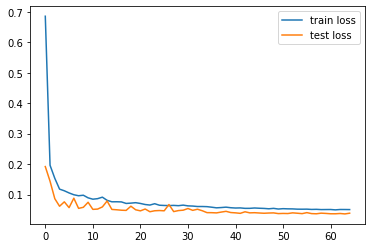

In [42]:
plt.plot(result1.history['loss'], label = 'train loss')
plt.plot(result1.history['val_loss'], label = 'test loss')
plt.legend()

In [43]:
model_allvars = tf.keras.models.load_model("Location_ANN_vars/model1_adam_ann.h5")
model_allvars.evaluate(Xval, yval)

71/71 [==============================] - 0s 3ms/step - loss: 0.0363 - mse: 0.0363


[0.03633230924606323, 0.03633230924606323]

In [44]:
test_observed = test_target3['Fold 0'].to_numpy().reshape(-1, 1)
test_predicted = np.exp(model_allvars.predict(scaled_test_set3['Fold 0']))
r2 = r2_score(test_observed, test_predicted)
n = test_observed.shape[0]
p = 9
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

print("Fold " + str(0) + " Test R2 score:", np.round(r2, 4))
print("Fold " + str(0) + " Test Adjusted R2 score:", np.round(adjusted_r2, 4))
print()

Fold 0 Test R2 score: 0.8776
Fold 0 Test Adjusted R2 score: 0.8771



In [5]:
###Based on the result above we will use this model architecture
###Apply this on 5-fold cv to consider the result
Test_R2_list = list()
Test_adjusted_R2_list = list()
Train_R2_list = list()
rmse_list = list()
mae_list = list()

np.random.seed(123)
tf.random.set_seed(123)

input_shape = train_set3['Fold 0'].shape[1]
initial_learning_rate = 0.001
decay_steps = 990
decay_rate = 0.85
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, 
                                                             decay_rate, staircase=True)
Adam = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
model = ann_generator(input_shape)
model.compile(loss = 'mean_squared_error', optimizer = Adam, metrics = ['mse'])

for i in range(5):
    train_set = scaled_train_set3['Fold ' + str(i)]
    train_target = scaled_train_target3['Fold ' + str(i)]
    test_set = scaled_test_set3['Fold ' + str(i)]
    test_target = scaled_test_target3['Fold ' + str(i)]

    check_point = ModelCheckpoint('Location_ANN_vars/model1_adam_ann_' + 'Fold ' + str(i) + '.h5', 
                                   monitor = 'val_mse', save_best_only = True)
    model.fit(train_set, train_target, epochs = 80, validation_data = (test_set, test_target), 
              batch_size = 32, callbacks = [check_point], verbose = 0)
    model_allvars = tf.keras.models.load_model('Location_ANN_vars/model1_adam_ann_' + 'Fold ' + str(i) + '.h5')
    train_observed = train_target3['Fold ' + str(i)].to_numpy().reshape(-1, 1)
    train_predicted = np.exp(model_allvars.predict(train_set))
    train_r_squared = r2_score(train_observed, train_predicted)
        
    test_observed = test_target3['Fold ' + str(i)].to_numpy().reshape(-1, 1)
    test_predicted = np.exp(model_allvars.predict(test_set))
    test_r_squared = r2_score(test_observed, test_predicted)
    r2 = r2_score(test_observed, test_predicted)
    n = test_observed.shape[0]
    p = train_set.shape[1]
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    mse = mean_squared_error(test_observed, test_predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_observed, test_predicted)

    Test_R2_list.append(r2)
    Test_adjusted_R2_list.append(adjusted_r2)
    Train_R2_list.append(train_r_squared)
    rmse_list.append(rmse)
    mae_list.append(mae)
    
    print("Fold " + str(i + 1) + " Test R-squared score:", np.round(r2, 4))
    print("Fold " + str(i + 1) + " Test Adjusted R-squared score:", np.round(adjusted_r2, 4))
    print("Fold " + str(i + 1) + " RMSE:", np.round(rmse, 4))
    print("Fold " + str(i + 1) + " MAE:", np.round(mae, 4))
    print()
    
dif = np.round(sum(Train_R2_list)/len(Train_R2_list), 4) - np.round(sum(Test_R2_list)/len(Test_R2_list), 4)
dif = np.round(dif * 100, 2)
print("The average Train R-squared : ", np.round(sum(Train_R2_list)/len(Train_R2_list), 4))
print("The average Test R-squared : ", np.round(sum(Test_R2_list)/len(Test_R2_list), 4))
print("The average Test adjusted R-squared: ", np.round(sum(Test_adjusted_R2_list)/len(Test_adjusted_R2_list), 4))
print("The average deviation from actual value (RMSE): ", np.round(sum(rmse_list)/len(rmse_list), 4))
print("The average deviation from actual value (MAE): ", np.round(sum(mae_list)/len(mae_list), 4))
print("Difference between Train vs. Test R-squared: ", dif, "%")

Fold 1 Test R-squared score: 0.9051
Fold 1 Test Adjusted R-squared score: 0.9047
Fold 1 RMSE: 12.6034
Fold 1 MAE: 7.3886

Fold 2 Test R-squared score: 0.9249
Fold 2 Test Adjusted R-squared score: 0.9246
Fold 2 RMSE: 13.9266
Fold 2 MAE: 7.5596

Fold 3 Test R-squared score: 0.8841
Fold 3 Test Adjusted R-squared score: 0.8837
Fold 3 RMSE: 16.1098
Fold 3 MAE: 7.6642

Fold 4 Test R-squared score: 0.8561
Fold 4 Test Adjusted R-squared score: 0.8556
Fold 4 RMSE: 17.3005
Fold 4 MAE: 10.4192

Fold 5 Test R-squared score: 0.9125
Fold 5 Test Adjusted R-squared score: 0.9122
Fold 5 RMSE: 16.4395
Fold 5 MAE: 10.1001

The average Train R-squared :  0.8889
The average Test R-squared :  0.8966
The average Test adjusted R-squared:  0.8961
The average deviation from actual value (RMSE):  15.276
The average deviation from actual value (MAE):  8.6263
Difference between Train vs. Test R-squared:  -0.77 %


In [5]:
###Based on the result I will pick this architecture for all the monthly location data
###Build a table that stores these results
###First build a function for monthly ANN model to track monthly performance
def location_ANN(Month, input_shape, scaled_train_set, scaled_train_target, true_train_target, 
                 scaled_test_set, scaled_test_target, true_test_target,
                 initial_learning_rate = 0.001, decay_steps = 990, decay_rate = 0.85):
    
    np.random.seed(123)
    tf.random.set_seed(123)
    Test_R2_list = list()
    Test_adjusted_R2_list = list()
    Train_R2_list = list()
    rmse_list = list()
    mae_list = list()

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, 
                                                                 decay_rate, staircase=True)
    Adam = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
    model = ann_generator(input_shape)
    model.compile(loss = 'mean_squared_error', optimizer = Adam, metrics = ['mse'])
    
    Monthly_path = 'Monthly_location_ANN/' + Month
    if not os.path.exists(Monthly_path):
        os.makedirs(Monthly_path)
    
    for i in range(5):
        train_set = scaled_train_set['Fold ' + str(i)]
        train_target = scaled_train_target['Fold ' + str(i)]
        test_set = scaled_test_set['Fold ' + str(i)]
        test_target = scaled_test_target['Fold ' + str(i)]
        check_point = ModelCheckpoint(Monthly_path + '/model1_adam_ann_' + 'Fold ' + str(i) + '.h5', 
                                       monitor = 'val_mse', save_best_only = True)
        model.fit(train_set, train_target, epochs = 80, validation_data = (test_set, test_target), 
                  batch_size = 32, callbacks = [check_point], verbose = 0)
        model_allvars = tf.keras.models.load_model(Monthly_path + '/model1_adam_ann_' + 'Fold ' + str(i) + '.h5')
        train_observed = true_train_target['Fold ' + str(i)].to_numpy().reshape(-1, 1)
        train_predicted = np.exp(model_allvars.predict(train_set))
        train_r_squared = r2_score(train_observed, train_predicted)

        test_observed = true_test_target['Fold ' + str(i)].to_numpy().reshape(-1, 1)
        test_predicted = np.exp(model_allvars.predict(test_set))
        test_r_squared = r2_score(test_observed, test_predicted)
        r2 = r2_score(test_observed, test_predicted)
        n = test_observed.shape[0]
        p = train_set.shape[1]
        adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
        mse = mean_squared_error(test_observed, test_predicted)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test_observed, test_predicted)

        Test_R2_list.append(r2)
        Test_adjusted_R2_list.append(adjusted_r2)
        Train_R2_list.append(train_r_squared)
        rmse_list.append(rmse)
        mae_list.append(mae)
    
    avg_Train_R2 = np.round(sum(Train_R2_list)/len(Train_R2_list), 4)
    avg_Test_R2 = np.round(sum(Test_R2_list)/len(Test_R2_list), 4)
    avg_Test_adjusted_R2 = np.round(sum(Test_adjusted_R2_list)/len(Test_adjusted_R2_list), 4)
    avg_Test_RMSE = np.round(sum(rmse_list)/len(rmse_list), 4)
    avg_Test_MAE = np.round(sum(mae_list)/len(mae_list), 4)
    dif = np.round(sum(Train_R2_list)/len(Train_R2_list), 4) - np.round(sum(Test_R2_list)/len(Test_R2_list), 4)
    dif = np.round(dif * 100, 2)
    
    month_performance = {Month: [avg_Train_R2, avg_Test_R2, avg_Test_adjusted_R2, avg_Test_RMSE, avg_Test_MAE, dif]}
    return month_performance

In [6]:
###Read in all the monthly data and runs both models on these data
###May be we should try 65 epochs instead for faster time
Month_list = ['July_2022', 'August_2022', 'September_2022', 'October_2022', 'November_2022',
              'December_2022', 'January_2023', 'February_2023', 'March_2023']
xgb_performance = dict()
ANN_performance = dict()

xg_reg = xgb.XGBRegressor(n_estimators = 100, eta = 0.15, objective ='reg:squarederror', min_split_loss = 0.4, 
                          reg_lambda = 1, reg_alpha = 0.75, max_depth = 6)


for month in Month_list:
    ###Read in all the datasets
    Month_path = 'Location_data3/' + month + '/' + month + '_houses_location.csv'
    df_location = pd.read_csv(Month_path)
    df_model = df_location.copy()[['latitude', 'longitude', 'county_lat', 'county_long', 'liv/lot_ratio', 
                                   'SD_lat', 'SD_long', 'zipcode_lat', 'zipcode_long', 'price/lotsqft']]
    
    ###Prep the data for ML/DL with 5 Folds-cv
    splits = 5
    scaler = MinMaxScaler()
    all_dicts = prep_data(splits, scaler, df_model)
    train_set = all_dicts[0]
    train_target = all_dicts[1]
    scaled_train_set = all_dicts[2]
    scaled_train_target = all_dicts[3]
    test_set = all_dicts[4]
    test_target = all_dicts[5]
    scaled_test_set = all_dicts[6]
    scaled_test_target = all_dicts[7]
    
    ###Run the ml on data
    avg_Train_R2, avg_Test_R2, avg_Test_adjusted_R2, avg_Test_RMSE, avg_Test_MAE, dif = location_ml(xg_reg, train_set, train_target, test_set, test_target, verbose = 0)
    xgb_performance[month] = [avg_Train_R2, avg_Test_R2, avg_Test_adjusted_R2, avg_Test_RMSE, avg_Test_MAE, dif]
    
    ###Run the dl on data
    true_train_target = train_target
    true_test_target = test_target
    input_shape = train_set['Fold 0'].shape[1]
    month_performance = location_ANN(month, input_shape, scaled_train_set, scaled_train_target, true_train_target, 
                                     scaled_test_set, scaled_test_target, true_test_target,
                                     initial_learning_rate = 0.001, decay_steps = 990, decay_rate = 0.85)
    ANN_performance.update(month_performance)

In [7]:
xgb_performance

{'July_2022': [0.9607, 0.8954, 0.8951, 14.8695, 8.0316, 6.53],
 'August_2022': [0.9577, 0.8964, 0.8961, 14.0722, 7.7559, 6.13],
 'September_2022': [0.9605, 0.9011, 0.9007, 13.0856, 7.4471, 5.94],
 'October_2022': [0.9589, 0.9048, 0.9045, 13.0337, 7.385, 5.41],
 'November_2022': [0.9607, 0.8994, 0.8991, 13.3223, 7.2929, 6.13],
 'December_2022': [0.962, 0.8877, 0.8872, 13.7695, 7.3383, 7.43],
 'January_2023': [0.9595, 0.8925, 0.8921, 13.65, 7.4706, 6.7],
 'February_2023': [0.9666, 0.9171, 0.9167, 12.1927, 7.0043, 4.95],
 'March_2023': [0.9677, 0.9052, 0.9048, 13.4326, 7.3117, 6.25]}

In [8]:
###If the algo had an issue, might have to run this by hand instead letting it runs by a loop
###Issue is fixed, do loop for convenience
ANN_performance

{'July_2022': [0.9063, 0.9055, 0.9052, 14.0646, 8.1351, 0.08],
 'August_2022': [0.9009, 0.9011, 0.9008, 13.7614, 7.9373, -0.02],
 'September_2022': [0.9091, 0.908, 0.9077, 12.6606, 7.678, 0.11],
 'October_2022': [0.8978, 0.8989, 0.8986, 13.4307, 7.9396, -0.11],
 'November_2022': [0.9119, 0.9118, 0.9115, 12.5621, 7.3303, 0.01],
 'December_2022': [0.9073, 0.9022, 0.9018, 12.8093, 7.4808, 0.51],
 'January_2023': [0.9079, 0.9073, 0.9069, 12.6606, 7.3687, 0.06],
 'February_2023': [0.9196, 0.9184, 0.9181, 12.0712, 7.112, 0.12],
 'March_2023': [0.9159, 0.9128, 0.9124, 12.8306, 7.2022, 0.31]}

In [9]:
df_XGBreg = pd.DataFrame.from_dict(xgb_performance, orient='index',
                                   columns=['Train_R_squared', 'Test_R_squared', 'Test_adj_R_squared',
                                            'Test_RMSE', 'Test_MAE', 'DIF'])
df_XGBreg

,Train_R_squared,Test_R_squared,Test_adj_R_squared,Test_RMSE,Test_MAE,DIF
July_2022,0.9607,0.8954,0.8951,14.8695,8.0316,6.53
August_2022,0.9577,0.8964,0.8961,14.0722,7.7559,6.13
September_2022,0.9605,0.9011,0.9007,13.0856,7.4471,5.94
October_2022,0.9589,0.9048,0.9045,13.0337,7.3850,5.41
November_2022,0.9607,0.8994,0.8991,13.3223,7.2929,6.13
December_2022,0.9620,0.8877,0.8872,13.7695,7.3383,7.43
January_2023,0.9595,0.8925,0.8921,13.6500,7.4706,6.70
February_2023,0.9666,0.9171,0.9167,12.1927,7.0043,4.95
March_2023,0.9677,0.9052,0.9048,13.4326,7.3117,6.25


In [11]:
df_XGBreg.to_csv('Model_performance/XGB_monthly_performance_location.csv', index = True)

In [12]:
df_ANN = pd.DataFrame.from_dict(ANN_performance, orient='index',
                                columns=['Train_R_squared', 'Test_R_squared', 'Test_adj_R_squared',
                                         'Test_RMSE', 'Test_MAE', 'DIF'])
df_ANN.to_csv('Model_performance/ANN_monthly_performance_location.csv', index = True)

#### Read in both model performance and plot their graphs

In [7]:
df_XGBreg = pd.read_csv('Model_performance/XGB_monthly_performance_location.csv', index_col = 0)
df_ANN = pd.read_csv('Model_performance/ANN_monthly_performance_location.csv', index_col = 0)
#bbox_to_anchor = (1, 1)

In [12]:
df_ANN

,Train_R_squared,Test_R_squared,Test_adj_R_squared,Test_RMSE,Test_MAE,DIF
July_2022,0.9063,0.9055,0.9052,14.0646,8.1351,0.08
August_2022,0.9009,0.9011,0.9008,13.7614,7.9373,-0.02
September_2022,0.9091,0.9080,0.9077,12.6606,7.6780,0.11
October_2022,0.8978,0.8989,0.8986,13.4307,7.9396,-0.11
November_2022,0.9119,0.9118,0.9115,12.5621,7.3303,0.01
December_2022,0.9073,0.9022,0.9018,12.8093,7.4808,0.51
January_2023,0.9079,0.9073,0.9069,12.6606,7.3687,0.06
February_2023,0.9196,0.9184,0.9181,12.0712,7.1120,0.12
March_2023,0.9159,0.9128,0.9124,12.8306,7.2022,0.31


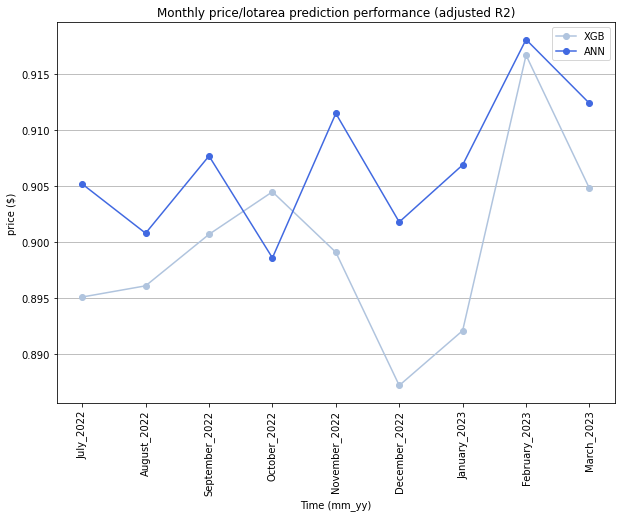

In [14]:
plt.figure(figsize = (10, 7))
plt.plot(df_XGBreg['Test_adj_R_squared'], label = 'XGB', marker = 'o', color = 'lightsteelblue')
plt.plot(df_ANN['Test_adj_R_squared'], label = 'ANN', marker = 'o', color = 'royalblue')
plt.legend()
plt.xticks(rotation = 'vertical')
plt.xlabel('Time (mm_yy)')
plt.ylabel('price ($)')
plt.title('Monthly price/lotarea prediction performance (adjusted R2)')
plt.grid(axis = 'y')
plt.show()

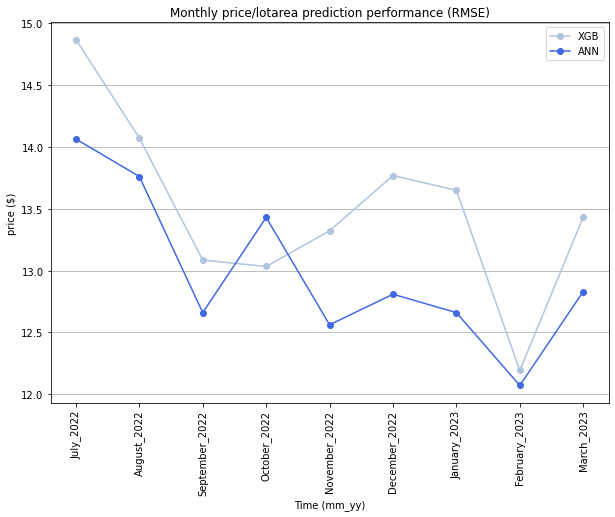

In [15]:
plt.figure(figsize = (10, 7))
plt.plot(df_XGBreg['Test_RMSE'], label = 'XGB', marker = 'o', color = 'lightsteelblue')
plt.plot(df_ANN['Test_RMSE'], label = 'ANN', marker = 'o', color = 'royalblue')
plt.legend()
plt.xticks(rotation = 'vertical')
plt.xlabel('Time (mm_yy)')
plt.ylabel('price ($)')
plt.title('Monthly price/lotarea prediction performance (RMSE)')
plt.grid(axis = 'y')
plt.show()

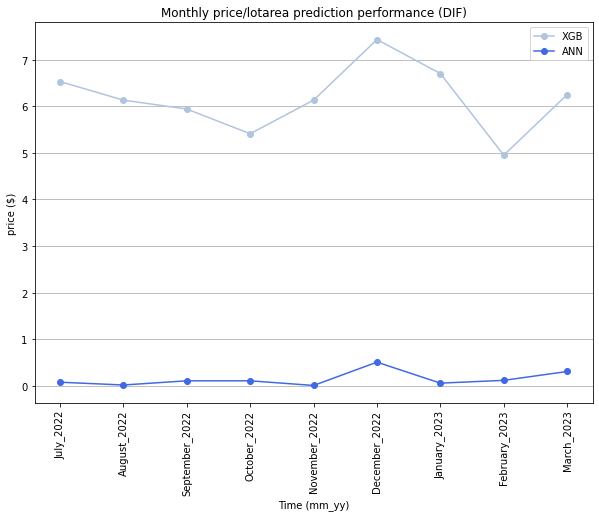

In [17]:
plt.figure(figsize = (10, 7))
plt.plot(abs(df_XGBreg['DIF']), label = 'XGB', marker = 'o', color = 'lightsteelblue')
plt.plot(abs(df_ANN['DIF']), label = 'ANN', marker = 'o', color = 'royalblue')
plt.legend()
plt.xticks(rotation = 'vertical')
plt.xlabel('Time (mm_yy)')
plt.ylabel('price ($)')
plt.title('Monthly price/lotarea prediction performance (DIF)')
plt.grid(axis = 'y')
plt.show()

###### Bug fixing section

In [40]:
###Why do July and December 2022 mess up the DL network?
##July has a liv/lot ratio > 1, which is wrong, same for December

df_location2 = pd.read_csv('Location_data3/December_2022/December_2022_houses_location.csv')
df_location2

,zpid,latitude,longitude,county_lat,county_long,SD_lat,SD_long,zipcode_lat,zipcode_long,price/livingsqft,price/lotsqft,liv/lot_ratio
0,2.201139e+08,33.043804,-97.398170,33.219095,-97.653997,33.033006,-97.354880,33.093365,-97.462793,168.230144,42.588898,0.253159
1,7.894006e+07,33.174137,-97.868740,33.219095,-97.653997,33.157978,-97.816943,33.160060,-97.840034,105.374078,29.182425,0.276941
2,2.201031e+08,33.418247,-97.753296,33.219095,-97.653997,33.379846,-97.701165,33.461447,-97.758976,182.239894,1.856803,0.010189
3,7.894409e+07,33.004993,-97.804665,33.219095,-97.653997,32.982927,-97.867913,32.970044,-97.733748,258.035714,0.534396,0.002071
4,2.061609e+09,33.263832,-97.880040,33.219095,-97.653997,33.326269,-97.829165,33.302787,-97.868426,149.576060,34.082954,0.227864
...,...,...,...,...,...,...,...,...,...,...,...,...
11355,9.889846e+07,32.543800,-97.011894,32.346878,-96.796940,32.472297,-97.000465,32.584814,-96.972312,261.482492,26.321403,0.100662
11356,3.312331e+08,32.348778,-96.840440,32.346878,-96.796940,32.356339,-96.863493,32.371654,-96.803030,264.900662,28.466483,0.107461
11357,9.890180e+07,32.524220,-96.894200,32.346878,-96.796940,32.472297,-97.000465,32.524259,-96.809069,799.507995,1.544699,0.001932
11358,2.066871e+09,32.539078,-96.842514,32.346878,-96.796940,32.515389,-96.811019,32.524259,-96.809069,209.279070,26.485720,0.126557


In [41]:
df_location2.isna().sum()

zpid                0
latitude            0
longitude           0
county_lat          1
county_long         1
SD_lat              0
SD_long             0
zipcode_lat         0
zipcode_long        0
price/livingsqft    0
price/lotsqft       0
liv/lot_ratio       0
dtype: int64

In [38]:
###Error 1: liv/lot shouldn't be greater than 10 (July 2022)
###Solution: Keep every houses with liv/lot_ratio < 2, we only lose 10-20 houses though.
###Error 2: Somehow the county for one house didn't show up.
###Solution: Just fill it up the house location
df_location2.iloc[:, 1:].min(axis = 0)

latitude            32.121685
longitude          -98.057150
county_lat          32.346878
county_long        -97.805905
SD_lat              32.150464
SD_long            -98.132984
zipcode_lat         32.136018
zipcode_long       -98.142546
price/livingsqft    16.424124
price/lotsqft        0.347441
liv/lot_ratio        0.000628
dtype: float64